# General TDA pipeline

**Author:** Erik Am&eacute;zquita

**Date:** November 2025

This is a short notebook on how to compare 2 or more persistence diagrams using:
- Bottleneck distances
- Wasserstein distances
- Persistence images
- MDS (Multidimensional scaling)
- PCA (Principal component analysis)

This is by no means an exhaustive list of things to do, but it (hopefully) will provide a good starting point from which finer analyses can be devised.

**Important**: In this example, we'll look at diagrams drawn from Vietoris-Rips filtrations, but keep in mind that you can use the same outlined pipeline with any other collection of diagrams drawn from any other filtrations.

# Part I: Imports

We start importing some standard libraries and sublibraries for non-TDA stuff. For the TDA-specific computations, we'll use `ripser` and `persim` (part of `scikit-tda`).

*Optional*: For this Notebook, you can also use `gudhi`. When it comes to computing the Wasserstein distance with `gudhi`, make sure that there are no conflicts between `POT` and `scipy`. You might need to either install compatible versions (using a virtual environment) or make a small edit to the `POT` files. [Check here for examples of `scipy` vs `POT` fixes](https://github.com/thaler-lab/Wasserstein/issues/36).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition, manifold, metrics, preprocessing
from scipy import spatial


from ripser import ripser
import persim

# Optional: comment them if the Wasserstein distances report errors
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

Some general variables so we don't worry about them later. Changing them won't have much of an impact later.
- `fs`: fontsize for plots
- `colors`: list of colors for matplotlib
- `markers`: list of markers for matplotlib
- `legend_kw`: parameters for the matplotlib legends
- `mds_kw`: parameters to compute MDS
- `rng`: random number generator with a fixed seed for reproducibility purposes

In [2]:
fs = 14
colors = ['coral','dodgerblue']
markers =  ['s', 'D']
rng = np.random.default_rng(42)
legend_kw = dict(facecolor='gainsboro', framealpha=1, borderpad=0)
mds_kw = dict(n_components=2, max_iter=3000,  eps=1e-9, n_init=1, random_state=42, dissimilarity="precomputed", n_jobs=1)

# Part II: Setup

- We'll define 2 different groups of 2D pointclouds, with `N=5` pointclouds per group. (10 pointclouds total).
- Each pointcloud will have `M=100` points
- For the first group, the points will be drawn from a uniform distribution.
- The second group will have its points drawn from a normal distribution
- For each point cloud, we'll compute its persistence diagram (Vietoris-Rips in this case)

**Important**: To avoid weird errors down the line, from the diagrams we have removed the features with infinite lifetime.

In [3]:
M,N = 100,5
dgms = [None for _ in range(2*N)]

data = rng.uniform(size=(N*M,2))
for i in range(0,len(data),M):
    diags = ripser(data[i:i+M])
    dgms[i//M] = [ diags['dgms'][hdim][ np.all(diags['dgms'][hdim] < np.inf, axis = 1) ] for hdim in range(len(diags['dgms'])) ]

data = rng.normal(size=(N*M,2))
for i in range(0,len(data),M):
    diags = ripser(data[i:i+M])
    dgms[N + i//M] = [ diags['dgms'][hdim][ np.all(diags['dgms'][hdim] < np.inf, axis = 1) ] for hdim in range(len(diags['dgms'])) ]

# Get the max value across all diagrams: only used for visualization purposes
maxval = max([max(map(np.max, dgm)) for dgm in dgms ])

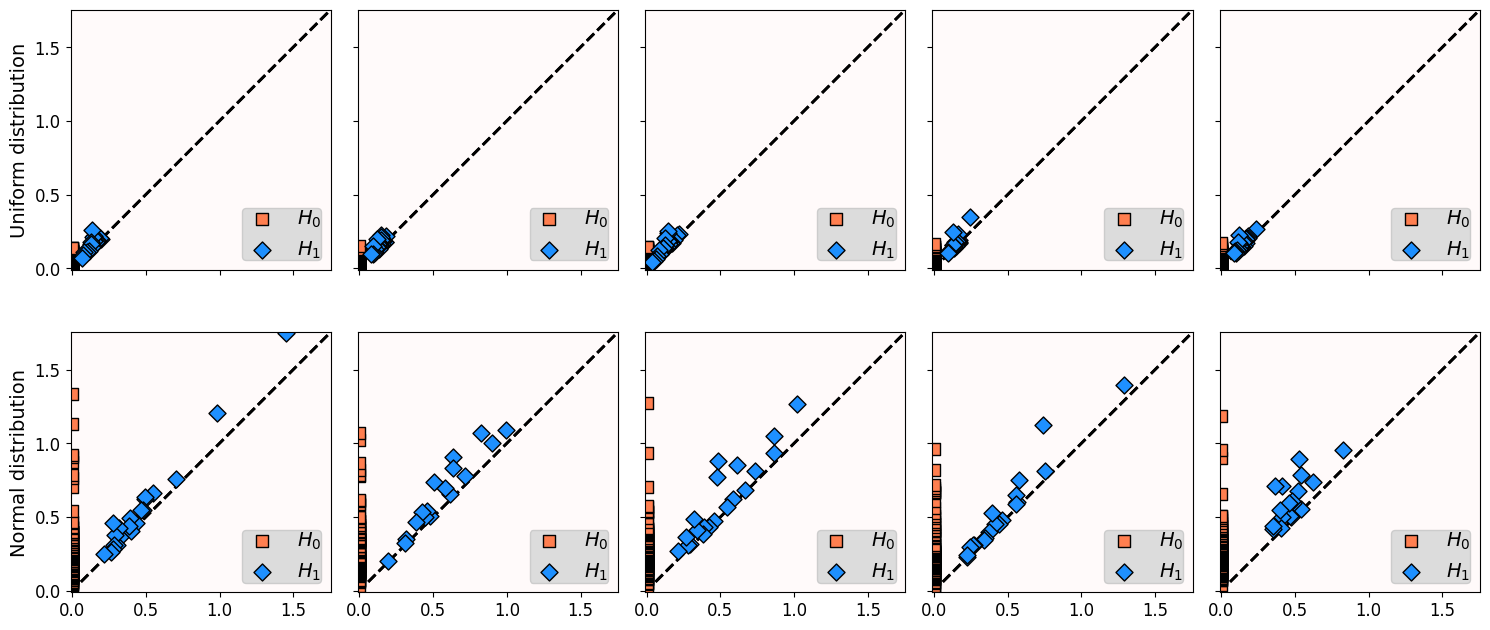

In [5]:
fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    for j in range(len(dgms[i])):
        ax[i].axline((0,0), slope=1, ls='dashed', lw=2, zorder=1, c='k')
        ax[i].scatter(*dgms[i][j].T, s=75, fc=colors[j], ec='k', marker=markers[j], label='$H_{{{}}}$'.format(j), zorder=2)
        ax[i].legend(loc='lower right', fontsize=fs, **legend_kw)

    # Make the plots prettier
    ax[i].set_facecolor('snow')
    ax[i].set_xlim(-0.01, maxval+0.01)
    ax[i].set_ylim(-0.01, maxval+0.01)
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelsize=.85*fs)

ax[0].set_ylabel('Uniform distribution', fontsize=fs)
ax[N].set_ylabel('Normal distribution', fontsize=fs)
fig.tight_layout()

## Consider one dimension only 

We'll focus on $H_1$ since it is the one that looks the most interesting. The exact same pipeline works when looking at $H_0$. 

**Important**: Never mix the points of one dimension with the points of another dimension.

In [4]:
hdim = 1

# Part III: Computing distances between diagrams

The first we can do is to compute a distance between diagrams to know how similar (different) they are from each other. Ideally, diagrams originating from similar shapes/patterns will have a short distance between them. And diagrams originating from different shapes will have longer distances.

## The bottleneck distance

Historically, the first distance proposed to compare two persistence diagrams $D_1, D_2$ was the *bottleneck* distance. Consider a match (bijection) $\varphi$ between all the points of $D_1$ and $D_2$ (remember that the diagrams include all the points on the diagonal). Two possible matches between blue triangles and red circles are illustrated below (Fig. 8 in [Am&eacute;zquita et al 2020](https://doi.org/10.1002/dvdy.175)). 

![](https://anatomypubs.onlinelibrary.wiley.com/cms/asset/43c4001d-0953-4582-b3dc-eee5c47bf39c/dvdy175-fig-0008-m.jpg)

For each match, we consider its cost as the largest difference across all matched points. In the example above, the match on the left has a higher cost that the match on the right. The bottleneck distance corresponds to the lowest possible cost considering all possible matches. More formally:

$$d_B(D_1, D_2) := \inf_{\varphi:D_1\to D_2}\;\sup_{x\in D_1}\|x - \varphi(x)\|_\infty.$$

Intuitively, the bottleneck distance measures what is the minimum cost to match the topology of one shape to the topology of another shape.

The bottleneck distance is *stable*, in the sense that if the original shapes wiggle a little bit (say because of noise), then the bottleneck distance between the resulting diagrams will only change a little bit. More formally, [Cohen-Steiner et al 2007](https://doi.org/10.1007/s00454-006-1276-5) show that:

$$d_B(D_1, D_2) \leq \|f_1 - f_2\|_\infty,$$

where $f_i$ is the filtration that produces diagram $D_1$.

## Pairwise distance matrix

For our toy example, we will compute the bottleneck distances between all possible pairs. Note that this matrix has zeros in its diagonal and it is symmetric. Ideally, the distance between the first five diagrams (points produced with uniform distribution) should be small, and the distance between the last five diagrams (produced with normal distribution) should be small as well. Also, the distance between the first five and the last five should be large.

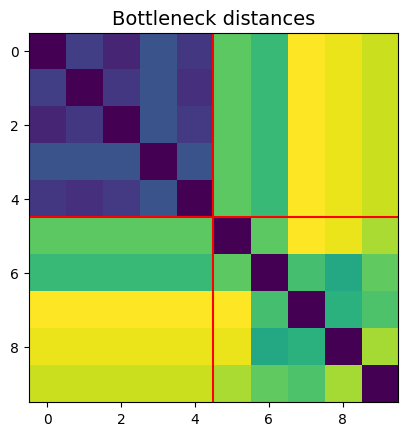

In [8]:
bns = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        bn = persim.bottleneck(dgms[i][hdim], dgms[j][hdim], matching=False)
        # Alternative way to compute bottleneck distance with gudhi
        #bn = gd.bottleneck_distance(dgms[i][hdim], dgms[j][hdim])
        bns[i,j] = bn
        bns[j,i] = bn
plt.imshow(bns);
plt.axvline(N-.5, c='r')
plt.axhline(N-.5, c='r')
plt.title('Bottleneck distances', fontsize=fs);

Welp, that was not the ideal. The first five diagrams are indeed close to each other. But the last five are all over the place and it is impossible to tell if they are related or not.

## MDS: Multidimensional Scaling

To have a better sense of these distances, we can represent them in a plane [via MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling). This is an algorithm that tries to represent in 2D the present distances in the most faithful way possible. That is, if two diagrams are close to each other (in bottleneck distance terms), they will also be close to each other in 2D in their MDS representation. And viceversa: diagrams that are far apart should be represented as two points far apart in the 2D representation.

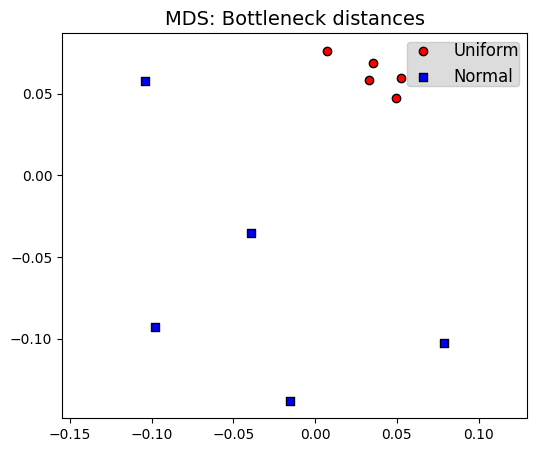

In [18]:
X_mds = manifold.MDS(**mds_kw).fit(bns).embedding_

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax.scatter(*X_mds[5:].T, fc='b', ec='k', marker='s', label='Normal')
ax.legend(fontsize=0.85*fs, **legend_kw)
ax.set_aspect('equal', 'datalim')
ax.set_title('MDS: Bottleneck distances', fontsize=fs);

Sure enough, the uniform diagrams are all close to each other as expected from the pairwise distance matrix. And the normal diagrams are distinct from the uniform ones. But it is hard to say if the normal diagrams are related to each other.

## The Wasserstein distance

An alternative (or generalization to be more precise) of the bottleneck distance is the Wasserstein distance. Instead of considering the match cost as the largest difference, we will consider the *sum* of all differences. The $q$-th order Wasserstein distance is defined as:

$$W_q(D_1, D_2) := \inf_{\varphi:D_1\to D_2}\left(\sum_{x\in D_1}\|x-\varphi(x)\|_\infty\right)^{1/q}.$$

Notice that when $q=\infty$, the Wasserstein distance becomes the bottleneck distance. The Wasserstein distance is also stable ([Mileyko et al 2011](https://doi.org/10.1088/0266-5611/27/12/124007)):

$$W_q(D_1, D_2) \leq C^{1/q}\|f_1 - f_2\|_\infty^{1-k/q},$$

(ignore the actual values of $C$ and $k$) whenever the filtration functions $f_1, f_2$ are nice enough (for some definition of nice).

For persistence image purposes, we'll use $q=1$. This is the $q$ value used internally by `persim` when computing Wasserstein. `gudhi` let's you compute Wassertein for any $q$ (order) and $L_p$ norm (instead of just $L_\infty$) as in the original definition.

## Rinse and repeat

We can again compute a pairwise distance matrix and visualize these results in 2D via MDS. Unfortunately there is not that much of a difference in this case between bottleneck and Wasserstein.

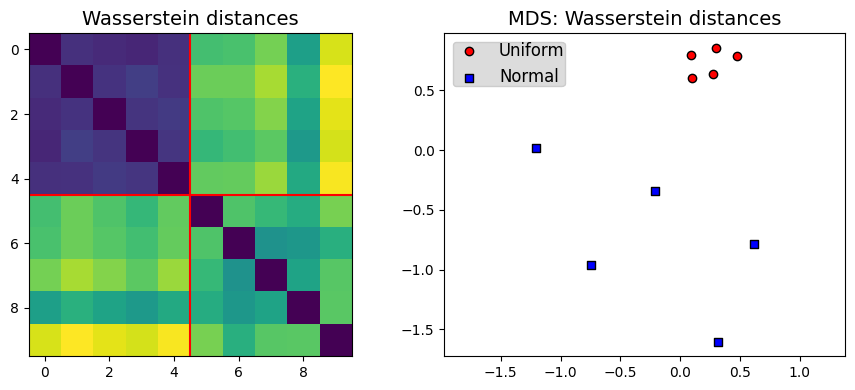

In [19]:
wds = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        wd = persim.wasserstein(dgms[i][hdim], dgms[j][hdim], matching=False)

        # With gudhi you compute various values of q (order) and do instead
        #wd = wasserstein_distance(dgms[i][hdim], dgms[j][hdim], order=1)
        wds[i,j] = wd
        wds[j,i] = wd

X_mds = manifold.MDS(**mds_kw).fit(wds).embedding_

fig, ax = plt.subplots(1,2, figsize=(9,4))

ax[0].imshow(wds);
ax[0].axvline(N-.5, c='r')
ax[0].axhline(N-.5, c='r')
ax[0].set_title('Wasserstein distances', fontsize=fs);

ax[1].scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax[1].scatter(*X_mds[5:].T, fc='b', ec='k', marker='s', label='Normal')
ax[1].legend(fontsize=0.85*fs, **legend_kw);
ax[1].set_aspect('equal', 'datalim')
ax[1].set_title('MDS: Wasserstein distances', fontsize=fs);

fig.align_titles()
fig.tight_layout()

# Part IV: Kernel representations of persistence diagrams &rarr; Persistence images

So far we have worked directly with the diagrams. Persistence diagrams are very *weird* mathematical objects. It is mathematically impossible to do much statistics beyond what we've already tried. For starters, there is no such thing as an *average* persistence diagram (no, averaging the points does not work) ([Munch et al 2015](https://doi.org/10.1214/15-EJS1030)).

Instead, we can first transform the diagrams into a much nicer mathematical object, and then we can do all the statistics we want with it. This is called a *kernel representation*. There are various kernels available that will produce different nice mathematical objects. We'll focus on *persistence images*, which represent persistent diagrams as everyday vectors.

First we need to re-think our persistence diagram as a *lifetime* diagram (`lifetime = death - birth`, essentially rotating it 45 degrees clockwise). Then we compute a weighted KDE (*kernel density estimate*, think of a heatmap) based on lifetime. This produces a *persistence surface*.

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/refs/heads/main/mcarto/figs/GLYMA_05G092200_TDA_c02352_12.png)

This surface can then be discretized by a relatively small number of pixels. This produces a *persistence image* than can be thought as a long vector (as opposed to a matrix.)

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/refs/heads/main/mcarto/figs/GLYMA_05G092200_TDA_c02352_13.png)


- For `persim` purposes, we need the largest possible birth time and lifetime to guarantee that all images will have the same dimensions and resolution (making them comparable).

1.4483269453048706	0.39502033591270447


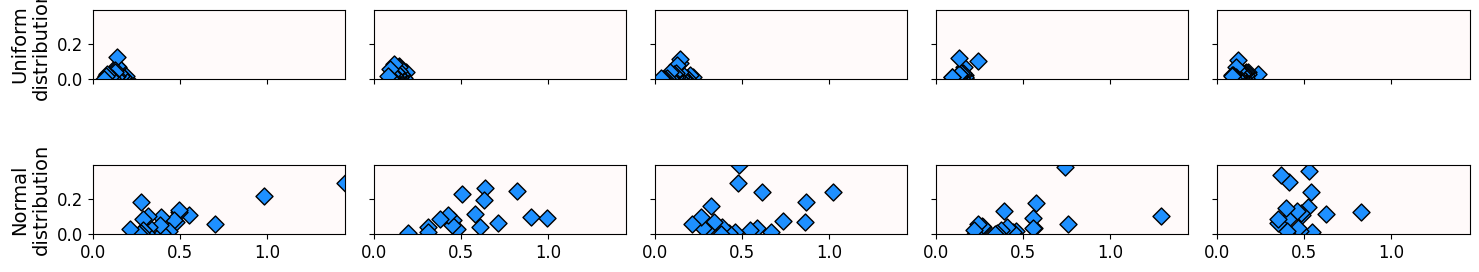

In [12]:
lt_h1 = [ np.column_stack((dgm[hdim][:,0], dgm[hdim][:,1]-dgm[hdim][:,0])) for dgm in dgms ]

max_birth, max_lt = np.max(np.vstack(lt_h1), axis=0)
print(max_birth, max_lt, sep='\t')

fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].scatter(*lt_h1[i].T, s=75, fc=colors[hdim], ec='k', marker=markers[hdim], label='$H_{{{}}}$'.format(hdim), zorder=2)

    ax[i].set_facecolor('snow')
    ax[i].set_xlim(0, max_birth)
    ax[i].set_ylim(0, max_lt)
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelsize=.85*fs)

ax[0].set_ylabel('Uniform\ndistribution', fontsize=fs)
ax[N].set_ylabel('Normal\ndistribution', fontsize=fs)
fig.tight_layout()

We'll need to set various parameters. The two most important are:

- `sigma`: How spread out is the *heat* from each point in the persistent surface? Large values will capture broad features but ignore details. Small sigmas will capture details but also noise. 

- `pixsz`: How much time does every pixel represent? Large pixel values will result in very pixelated images that will capture broad features but ignore detail. Small pixel sizes will capture details but also noise: they will also produce large vectors that could be affected by the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

For both cases, *large* and *small* are relative to the largest birth and life times. I chose `pixsz = 0.15` so that the resulting images would be 5 pixels tall by 12 pixels long. So only 60 values total per diagram.

In [13]:
sigma = 0.25
pixsz = 0.15

# We make sure that the birth and lifetime ranges are integer multiples of pixel size.
pi_params = {'birth_range':(0, pixsz * np.ceil((max_birth + sigma)/pixsz)),
             'pers_range':(0, pixsz * np.ceil((max_lt + sigma)/pixsz)),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': 1},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }

# Define a transformer with fixed parameters so all the diagrams will be treated exactly the same
# (so they'll be comparable)
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ])
print(extent)

# Transform the lifetime diagrams into persistence images
pimgs = np.asarray(pimgr.transform(lt_h1, skew=False))
pi_vmax = np.max(pimgs)
print(pimgs.shape)

[0.   1.8  0.   0.75]
(10, 12, 5)


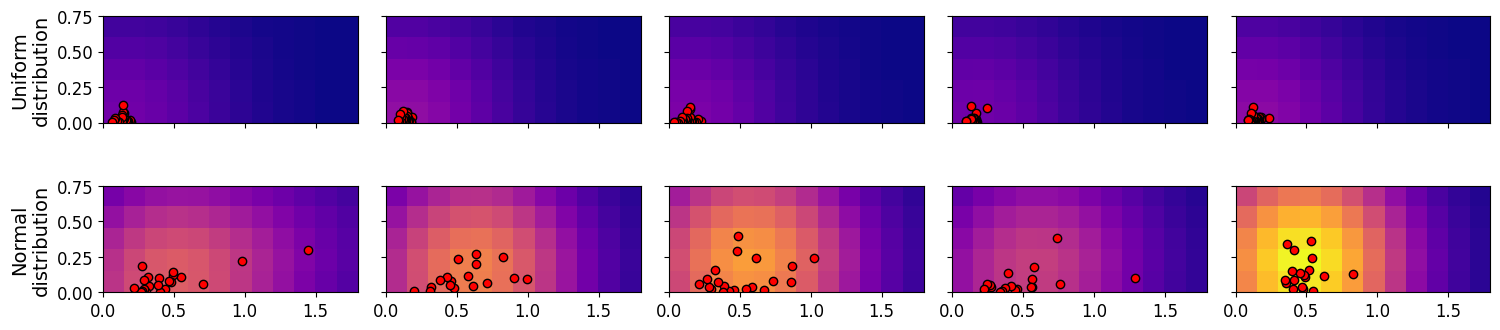

In [14]:
# Plot the images and overlay the lifetime diagram. Compare it with the lifetime diagrams plotted above

fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].imshow(pimgs[i].T, origin='lower', cmap='plasma', vmin=0, vmax=pi_vmax, extent=extent)
    ax[i].scatter(*lt_h1[i].T, marker='o', fc='r', ec='k', zorder=2)
    #ax[i].legend(loc='upper right', fontsize=0.85*fs, facecolor='gainsboro', framealpha=1, borderpad=0)

    ax[i].tick_params(labelsize=.85*fs)

ax[0].set_ylabel('Uniform\ndistribution', fontsize=fs)
ax[N].set_ylabel('Normal\ndistribution', fontsize=fs)
fig.tight_layout()

### Rinse and repeat

We can compute the Euclidean distance between these vectors and obtain a new distance matrix and MDS representation. In this case, we get results closer to our expected ideal.

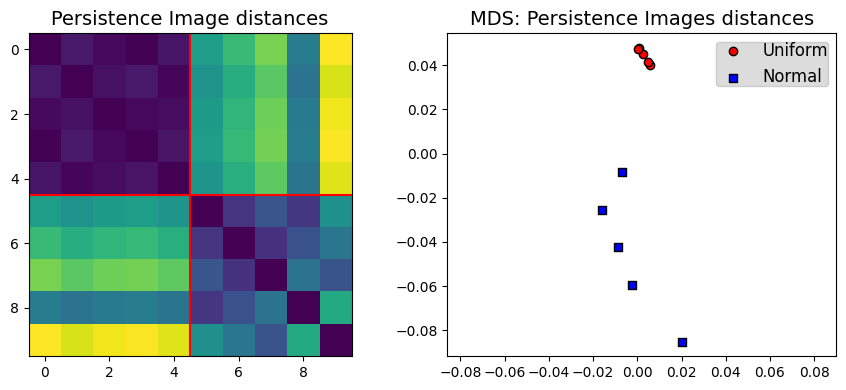

In [20]:
pids = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        pid = np.sqrt(np.sum((pimgs[j] - pimgs[i])**2))
        pids[i,j] = pid
        pids[j,i] = pid
X_mds = manifold.MDS(**mds_kw).fit(pids).embedding_


fig, ax = plt.subplots(1,2, figsize=(9,4))

ax[0].imshow(pids);
ax[0].axvline(N-.5, c='r')
ax[0].axhline(N-.5, c='r')
ax[0].set_title('Persistence Image distances', fontsize=fs);

ax[1].scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax[1].scatter(*X_mds[5:].T, fc='b', ec='k', marker='s', label='Normal')
ax[1].legend(fontsize=0.85*fs, **legend_kw);
ax[1].set_aspect('equal', 'datalim')
ax[1].set_title('MDS: Persistence Images distances', fontsize=fs);

fig.align_titles()
fig.tight_layout()

## Concatenating dimensions

Another big advantage of kernel representations like persistence images is that it is much more obvious how to take into account information from all dimensions at once. We still need to make separate computations for $H_0$- and $H_1$-derived images, but then we can simply concatenate the vectors.

In [21]:
lt_h0 = [ np.column_stack((dgm[0][:,0], dgm[0][:,1]-dgm[0][:,0])) for dgm in dgms ]
lt_h1 = [ np.column_stack((dgm[hdim][:,0], dgm[hdim][:,1]-dgm[hdim][:,0])) for dgm in dgms ]

max_birth, max_lt = np.max(np.vstack(lt_h0 + lt_h1), axis=0)
print(max_birth, max_lt, sep='\t')

# We make sure that the birth and lifetime ranges are integer multiples of pixel size.
pi_params = {'birth_range':(0, pixsz * np.ceil((max_birth + sigma)/pixsz)),
             'pers_range':(0, pixsz * np.ceil((max_lt + sigma)/pixsz)),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': 1},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }

# Define a transformer with fixed parameters so all the diagrams (FOR ALL DIMENSIONS) will be treated exactly the same
# (so they'll be comparable)
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ])
print(extent)

# Transform the lifetime diagrams into persistence images
pimgs0 = np.asarray(pimgr.transform(lt_h0, skew=False))
pimgs1 = np.asarray(pimgr.transform(lt_h1, skew=False))

pi_vmax0 = np.max(pimgs0)
pi_vmax1 = np.max(pimgs1)

print(pimgs0.shape, pimgs1.shape, sep='\t')

1.4483269453048706	1.3319292068481445
[0.   1.8  0.   1.65]
(10, 12, 11)	(10, 12, 11)


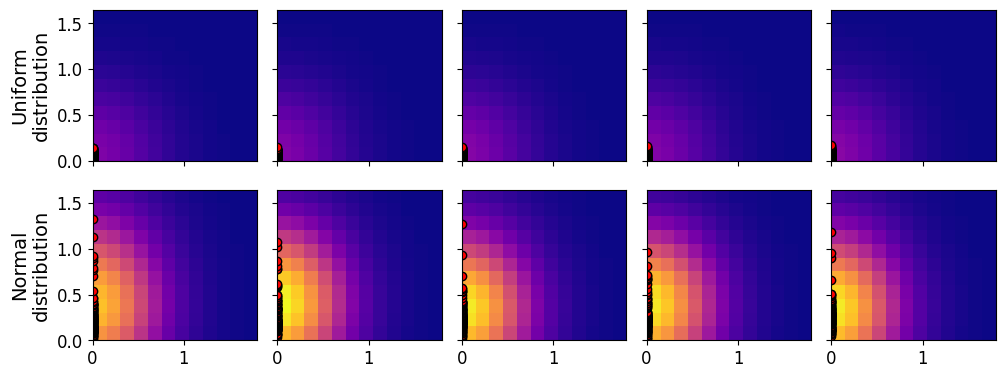

In [39]:
# Plot the images for H0 and overlay the lifetime diagram.

fig, ax = plt.subplots(2, len(dgms)//2, figsize=(10, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].imshow(pimgs0[i].T, origin='lower', cmap='plasma', vmin=0, vmax=pi_vmax0, extent=extent)
    ax[i].scatter(*lt_h0[i].T, marker='o', fc='r', ec='k', zorder=2)
    #ax[i].legend(loc='upper right', fontsize=0.85*fs, facecolor='gainsboro', framealpha=1, borderpad=0)

    ax[i].tick_params(labelsize=.85*fs)

ax[0].set_ylabel('Uniform\ndistribution', fontsize=fs)
ax[N].set_ylabel('Normal\ndistribution', fontsize=fs)
fig.tight_layout()

(10, 264)


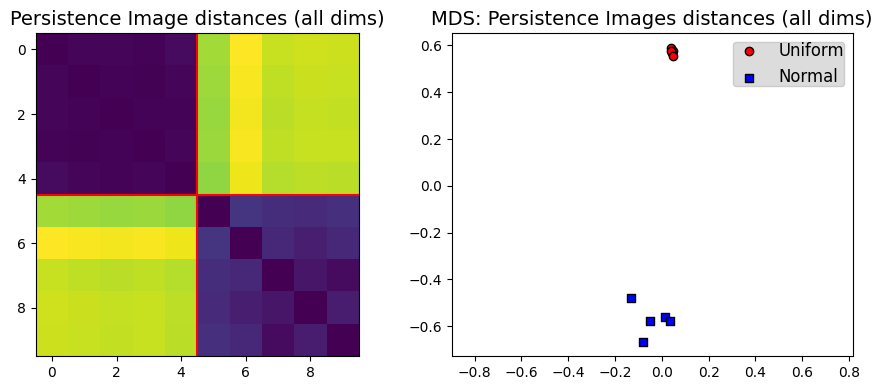

In [22]:
# Concatenate both dimensions into a single vector
# Now things look very much like the ideal!

pi0 = np.zeros((pimgs0.shape[0], pimgs0.shape[1]*pimgs0.shape[2]))
pi1 = pi0.copy()

for i in range(len(pi0)):
    pi0[i] = pimgs0[i].ravel()
    pi1[i] = pimgs1[i].ravel()

pi = np.hstack((pi0, pi1))
print(pi.shape)
pids = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        pid = np.sqrt(np.sum((pi[j] - pi[i])**2))
        pids[i,j] = pid
        pids[j,i] = pid

X_mds = manifold.MDS(**mds_kw).fit(pids).embedding_

fig, ax = plt.subplots(1,2, figsize=(9,4))

ax[0].imshow(pids);
ax[0].axvline(N-.5, c='r')
ax[0].axhline(N-.5, c='r')
ax[0].set_title('Persistence Image distances (all dims)', fontsize=fs);

ax[1].scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax[1].scatter(*X_mds[5:].T, fc='b', ec='k', marker='s', label='Normal')
ax[1].legend(fontsize=0.85*fs, **legend_kw);
ax[1].set_aspect('equal', 'datalim')
ax[1].set_title('MDS: Persistence Images distances (all dims)', fontsize=fs);

fig.align_titles()
fig.tight_layout()

## Part V: Beyond MDS

Since now we have vectors, we can do much more than distances and MDS. Each vector has 60 values: let's reduce that to two via PCA ([Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)). 

**Important**: Remember to center all the values before applying PCA. Standardizing the variance, while recommended as rule of thumb, is not needed in this case because all the pixel values are comparable to each other.

In [23]:
data = preprocessing.StandardScaler(copy=True, with_std=False, with_mean=True).fit_transform(pi)
print(data.shape)

PCA = decomposition.PCA(n_components=min([6, data.shape[1]//20]), random_state=42, svd_solver='full').fit(data)
print('Considering the first', PCA.n_components,'PCs')

pca = PCA.transform(data).astype('float32')
loadings = PCA.components_.T * np.sqrt(PCA.explained_variance_)
explained_ratio = 100*PCA.explained_variance_ratio_
print(explained_ratio)
print('Total explained var:\t', np.sum(explained_ratio), np.sum(explained_ratio[:2]))

(10, 264)
Considering the first 6 PCs
[9.93814742e+01 4.80700304e-01 1.19662664e-01 1.43154774e-02
 3.52058361e-03 2.34629207e-04]
Total explained var:	 99.99990782581258 99.8621744719656


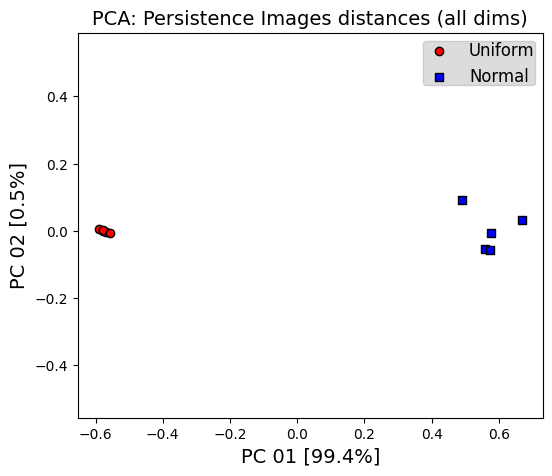

In [25]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

ax.scatter(*pca[:5, :2].T, fc='r', ec='k', marker='o', label='Uniform')
ax.scatter(*pca[5:, :2].T, fc='b', ec='k', marker='s', label='Normal')
ax.legend(fontsize=0.85*fs, **legend_kw);
ax.set_aspect('equal', 'datalim')
ax.set_title('PCA: Persistence Images distances (all dims)', fontsize=fs)
ax.set_xlabel('PC 01 [{:.1f}%]'.format(explained_ratio[0]), fontsize=fs)
ax.set_ylabel('PC 02 [{:.1f}%]'.format(explained_ratio[1]), fontsize=fs);

For our toy example, PCA produces the same result as MDS. Except that:
- PCA is much more computationally efficient than MDS: this is important if you are dealing with a large amount of data
- With PCA we can assign importance to each axis, unlike MDS.

---

# Now you are ready to explore your own data!